# Reddit `r/confession` Data Scraper

This project provides a Python-based scraper designed to extract and analyze data from the "Confessions" subreddit on Reddit. By automating data collection, this scraper facilitates efficient analysis and visualization of post interactions, sentiment, and user activity. Leveraging libraries like praw, pandas, and matplotlib, the scraper retrieves, processes, and transforms the data into a structured format for further insights.

## Data Extraction
The scraper sends requests to the Reddit API using PRAW to retrieve subreddit submission data. It processes the JSON response to extract relevant data points. The extracted data is organized into a pandas DataFrame, making it easy to manipulate and analyze. The DataFrame includes columns for each data point provided by the API.

In [2]:
# Imports
import os
import praw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from dotenv import load_dotenv
from textblob import TextBlob
%matplotlib inline

In [3]:
# Load environment variables from .env file
load_dotenv()

# Reddit API credentials
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
USER_AGENT = os.getenv("USER_AGENT")

# Initialize Reddit instance
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# Access the Confession subreddit
subreddit_name = 'confession'
subreddit = reddit.subreddit(subreddit_name)

# Scrape top posts from the subreddit
posts_data = [] 

# Get to the top 50 posts
for submission in subreddit.top(limit=50):
    time.sleep(2)
    submission.comments.replace_more(limit=0)
    tags = submission.link_flair_text
    if tags not in ['META']:
        post_info = {
            "url": submission.url,
            "timestamp": submission.created_utc,
            'author': submission.author.name if submission.author else 'Unknown',
            "title": submission.title,
            "story": submission.selftext,
            "upvotes": submission.score,
            "comment_count": submission.num_comments
        }
        posts_data.append(post_info)

# Convert to DataFrame
df = pd.DataFrame(posts_data)

# Display dataframe
df.head()

,url,timestamp,author,title,story,upvotes,comment_count
0,https://www.reddit.com/r/confession/comments/1...,1.737143e+09,Radyoz,Today’s my 28 birthday and I am going to end i...,"Hi I am 28 M and it’s 12:25am, I didn’t got a ...",70255,10124
1,https://www.reddit.com/r/confession/comments/c...,1.560628e+09,SpecialNeedsDevil,I'm putting my extremely profoundly disabled 7...,"I can't tell anyone this, even my therapist. L...",65634,2796
2,https://www.reddit.com/r/confession/comments/1...,1.734550e+09,Cheap-Tennis-7592,marrying for money sucks and I do not recommen...,Married a 40 year old when I was 19. Started d...,54873,5674
3,https://www.reddit.com/r/confession/comments/d...,1.571882e+09,hostilecarrot,I added Tabasco to Wendy’s chili and used it t...,Title basically says it all. This wasn’t a pro...,47895,1631
4,https://www.reddit.com/r/confession/comments/1...,1.739705e+09,popepipoes,I paid a couple of girls to feign interest in ...,"I’ve got a mate who’s nearly 30 now, to be hon...",42525,1125


In [4]:
# Get author activity
def get_user_activity(username):
    try:
        user = reddit.redditor(username)
        submissions = list(user.submissions.new(limit=None))  # Fetch all submissions
        comments = list(user.comments.new(limit=None))  # Fetch all comments
        
        # Calculate activity metrics
        author_submissions = len(submissions)
        author_comments = len(comments)
        return author_submissions, author_comments
    except Exception as e:
        # Return default values for private or inaccessible profiles
        return 1, 0

# Add user activity data to the DataFrame
df[['author_submissions', 'author_comments']] = df['author'].apply(
    lambda x: get_user_activity(x) if x != 'Unknown' else (None, None)
).apply(pd.Series)

In [5]:
# Add word count
df['word_count'] = df['story'].apply(lambda x: len(x.split()))

# Add unique word count
df['unique_word_count'] = df['story'].apply(lambda x: len(set(x.split())))

# Add character count
df['character_count'] = df['story'].apply(lambda x: len(x))

# Add sentiment analysis
df['sentiment'] = df['story'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Display the DataFrame
df.head()

,url,timestamp,author,title,story,upvotes,comment_count,author_submissions,author_comments,word_count,unique_word_count,character_count,sentiment
0,https://www.reddit.com/r/confession/comments/1...,1.737143e+09,Radyoz,Today’s my 28 birthday and I am going to end i...,"Hi I am 28 M and it’s 12:25am, I didn’t got a ...",70255,10124,2.0,4.0,1107,407,5608,0.101907
1,https://www.reddit.com/r/confession/comments/c...,1.560628e+09,SpecialNeedsDevil,I'm putting my extremely profoundly disabled 7...,"I can't tell anyone this, even my therapist. L...",65634,2796,1.0,16.0,1322,639,7154,0.084375
2,https://www.reddit.com/r/confession/comments/1...,1.734550e+09,Cheap-Tennis-7592,marrying for money sucks and I do not recommen...,Married a 40 year old when I was 19. Started d...,54873,5674,1.0,10.0,266,166,1360,0.032407
3,https://www.reddit.com/r/confession/comments/d...,1.571882e+09,hostilecarrot,I added Tabasco to Wendy’s chili and used it t...,Title basically says it all. This wasn’t a pro...,47895,1631,992.0,1160.0,75,62,396,0.020000
4,https://www.reddit.com/r/confession/comments/1...,1.739705e+09,popepipoes,I paid a couple of girls to feign interest in ...,"I’ve got a mate who’s nearly 30 now, to be hon...",42525,1125,369.0,1993.0,169,114,897,0.187500


## Data Preprocessing

The extracted data is processed to remove any missing values and unnecessary columns or rows, enhancing its usability for the end user.

In [6]:
# Check missing values
print("\nMissing values: ")
print(df.isna().sum())


Missing values: 
url                   0
timestamp             0
author                0
title                 0
story                 0
upvotes               0
comment_count         0
author_submissions    3
author_comments       3
word_count            0
unique_word_count     0
character_count       0
sentiment             0
dtype: int64


In [7]:
# Replace missing values
df["author_submissions"] = df["author_submissions"].fillna(1) # since they made 1 post
df["author_comments"] = df["author_comments"].fillna(0)
print("\nMissing values: ")
print(df.isna().sum())


Missing values: 
url                   0
timestamp             0
author                0
title                 0
story                 0
upvotes               0
comment_count         0
author_submissions    0
author_comments       0
word_count            0
unique_word_count     0
character_count       0
sentiment             0
dtype: int64


In [8]:
# Rename columns
df_copy = df.copy()
df_copy.columns = df_copy.columns.str.capitalize()
df_copy.rename({"Comment_count": "Comment Count", "Url": "URL", "Author_submissions": "Author Submissions", "Author_comments": "Author Comments", "Word_count": "Word Count", "Unique_word_count": "Unique Word Count", "Character_count": "Character Count"}, axis=1, inplace=True)
df_copy.head()

,URL,Timestamp,Author,Title,Story,Upvotes,Comment Count,Author Submissions,Author Comments,Word Count,Unique Word Count,Character Count,Sentiment
0,https://www.reddit.com/r/confession/comments/1...,1.737143e+09,Radyoz,Today’s my 28 birthday and I am going to end i...,"Hi I am 28 M and it’s 12:25am, I didn’t got a ...",70255,10124,2.0,4.0,1107,407,5608,0.101907
1,https://www.reddit.com/r/confession/comments/c...,1.560628e+09,SpecialNeedsDevil,I'm putting my extremely profoundly disabled 7...,"I can't tell anyone this, even my therapist. L...",65634,2796,1.0,16.0,1322,639,7154,0.084375
2,https://www.reddit.com/r/confession/comments/1...,1.734550e+09,Cheap-Tennis-7592,marrying for money sucks and I do not recommen...,Married a 40 year old when I was 19. Started d...,54873,5674,1.0,10.0,266,166,1360,0.032407
3,https://www.reddit.com/r/confession/comments/d...,1.571882e+09,hostilecarrot,I added Tabasco to Wendy’s chili and used it t...,Title basically says it all. This wasn’t a pro...,47895,1631,992.0,1160.0,75,62,396,0.020000
4,https://www.reddit.com/r/confession/comments/1...,1.739705e+09,popepipoes,I paid a couple of girls to feign interest in ...,"I’ve got a mate who’s nearly 30 now, to be hon...",42525,1125,369.0,1993.0,169,114,897,0.187500


#### Visualization for usability testing

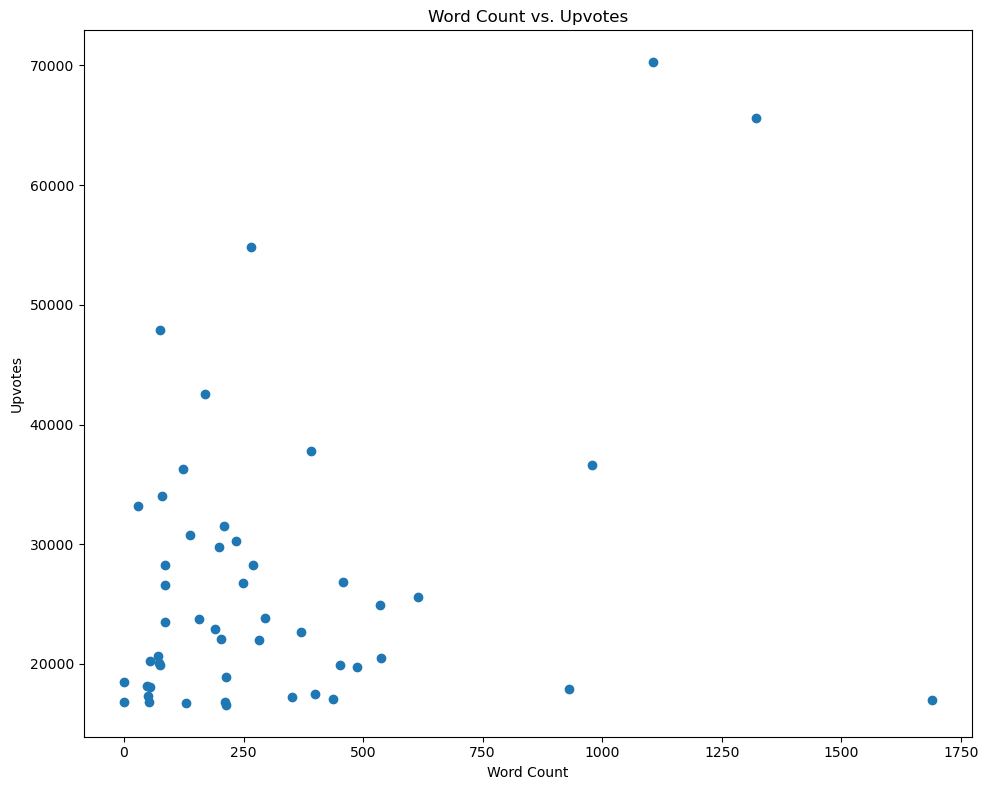

In [11]:
# Word Count vs. Upvotes Scatter Plot
plt.figure(figsize=(10, 8))
plt.scatter(df_copy['Word Count'], df_copy['Upvotes'])
plt.xlabel('Word Count')
plt.ylabel('Upvotes')
plt.title('Word Count vs. Upvotes')
plt.tight_layout()
plt.show()

## Data Exporting

The processed data is exported to both Excel and CSV formats. This allows analysts to perform further analysis using spreadsheet software or import the data into other analytical tools.

In [12]:
# File names
csv_file = 'reddit_confessions_data.csv'
excel_file = 'reddit_confessions_data.xlsx'

# Export to CSV
try:
    df_copy.to_csv(csv_file, index=False)
    print(f"Data exported to {csv_file}")
except PermissionError as e:
    print(f"Permission error while writing to {csv_file}: {e}")

# Export to Excel
try:
    df_copy.to_excel(excel_file, index=False, sheet_name='Top 50 rconfessions Data')
    print(f"Data exported to {excel_file}")
except PermissionError as e:
    print(f"Permission error while writing to {excel_file}: {e}")

Data exported to reddit_confessions_data.csv
Data exported to reddit_confessions_data.xlsx
